#### Libraries

In [1]:
import utils
from IPython.display import display, Image, Audio
import cv2
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip, AudioFileClip
import base64
import time
import openai
import os
import requests

### Download video from Youtube and cut it

In [81]:
# download video
utils.download_youtube_video("https://www.youtube.com/watch?v=N787WRdI35A")

# cut video from 2940 to 2975s
ffmpeg_extract_subclip("London Rain Walk in DESERTED West End Soho & Marylebone Streets - Saturday Morning City Ambience.mp4", 2940, 2975, targetname="video.mp4")

Video successfully downloaded to the current directory
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


### Read and resize video to 512x512 to avoid exceeding OpenAI token limit

In [89]:
video = cv2.VideoCapture("video.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    # resize to 512x512
    frame = cv2.resize(frame, (512,512))
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

1050 frames read.


### Check if video is ok

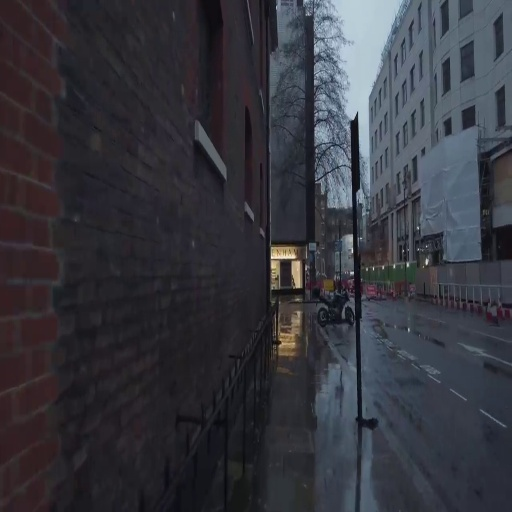

In [115]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

### Send video and prompt to GPT-4V(ision) using OpenAI API

In [113]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a person walking. Narrate succinctly like they do in GPS devices the elements and obstacles around you to help a blind person go through.",
            *map(lambda x: {"image": x}, base64Frames[0::100]),
        ],
    },
]

params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ['OPENAI_API_KEY'],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 400,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

You are walking on a city sidewalk under a covered area with shops on your right-hand side. Maintain a straight path. There are no immediate obstacles directly ahead of you.

Shortly, you will approach a signage board placed in the middle of the sidewalk, indicating roadwork ahead. Prepare to adjust your path slightly to the left to avoid it, then continue straight.

Following this, as you progress forward, be aware that the sidewalk narrows due to construction barriers ahead on the right side. You will need to keep to the left side of the sidewalk to pass safely.

Continuing on you can resume walking straight without significant obstacles.


### Create audio based on the GPT-4V(ision) output

In [111]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "fable",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

with open('audio.mp3', 'wb') as file:
    file.write(audio)

### Join together audio and video and save final clip

In [114]:
# Open the video and audio
video_clip = VideoFileClip("video.mp4")
audio_clip = AudioFileClip("audio.mp3")

# Concatenate the video clip with the audio clip
final_clip = video_clip.set_audio(audio_clip)

# save final video
final_clip.write_videofile("video_audio.mp4")

Moviepy - Building video video_audio.mp4.
MoviePy - Writing audio in video_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video_audio.mp4



Moviepy - Done !
Moviepy - video ready video_audio.mp4
